In [2]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image
import cv2 as cv
import numpy as np

/home/nef/anaconda3/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## DINO

First load the model and set device to CPU as no NVIDIA GPU is available to use CUDA

In [3]:
patch_size = 4
model = torch.hub.load('facebookresearch/dino:main', 'dino_vitb8')
# model = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')

# model = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16')
# model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
# model = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
# 


Using cache found in /home/nef/.cache/torch/hub/facebookresearch_dino_main


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

for p in model.parameters():
        p.requires_grad = False
        
model.eval();
model.to(device);

Manually add images

(-0.5, 1279.5, 719.5, -0.5)

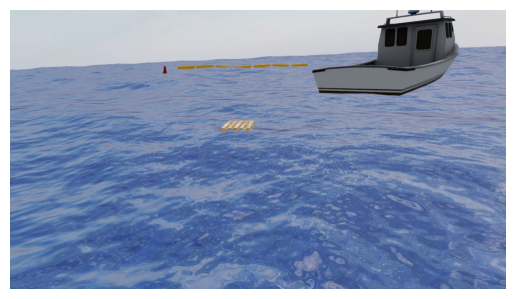

In [5]:
folder_path = r"/mnt/c/stereo_vision/04-04/"

file_name_L = "L_2_708.jpeg"
file_name_R = "R_2_708.jpeg"

imgL = cv.imread(folder_path + file_name_L, cv.IMREAD_COLOR)
imgR = cv.imread(folder_path + file_name_R, cv.IMREAD_COLOR)

imgL = cv.cvtColor(imgL, cv.COLOR_BGR2RGB)
imgR = cv.cvtColor(imgR, cv.COLOR_BGR2RGB)

fused_image_pil = Image.fromarray(imgL)

# fused_image_pil = fused_image_pil.resize((224, 224))

plt.imshow(fused_image_pil)
plt.axis("off")


### Extract Attentions

In [6]:
transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(fused_image_pil)
print(img.shape)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

#attentions = model.forward_selfattention(img.to(device))
attentions = model.get_last_selfattention(img)   #img.cuda()
print(attentions.shape)

#output is not an attention image.
output=model(img)
print(img.shape)
print(output.shape)

#get_last_selfattention
attentions = model.get_last_selfattention(img) 
print(img.shape)
print(attentions.shape)


nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
print(attentions.shape)

# we keep only a certain percentage of the mass
val, idx = torch.sort(attentions)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)

# # -----------------------
# threshold = 0.6
# # ----------------------
# th_attn = cumval > (1 - threshold)
# idx2 = torch.argsort(idx)
# for head in range(nh):
#     th_attn[head] = th_attn[head][idx2[head]]
    
# th_attn = th_attn.reshape(nh, w_featmap//2, h_featmap//2).float()

# # interpolate
# th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

attentions = attentions.reshape(nh, w_featmap//2, h_featmap//2)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
attentions_mean = np.mean(attentions, axis=0)

# print(attentions.shape)
print(attentions_mean.shape)

torch.Size([3, 720, 1280])


: 

(720, 1280)


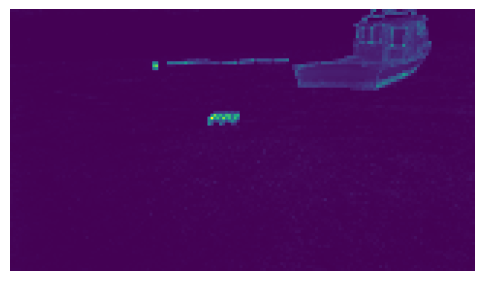

In [15]:
# Resize the attention map to match the original image size
attentions_mean_resized = nn.functional.interpolate(
    torch.tensor(attentions_mean).unsqueeze(0).unsqueeze(0),
    size=(720, 1280),
    mode="bilinear",
).squeeze().numpy()

print(attentions_mean_resized.shape)

plt.figure(figsize=(6,6), dpi=100)
# plt.xlim(0, 1280)
# plt.ylim(720, 0)
plt.imshow(attentions_mean)

plt.axis('off')
plt.show()

(-0.5, 1279.5, 719.5, -0.5)

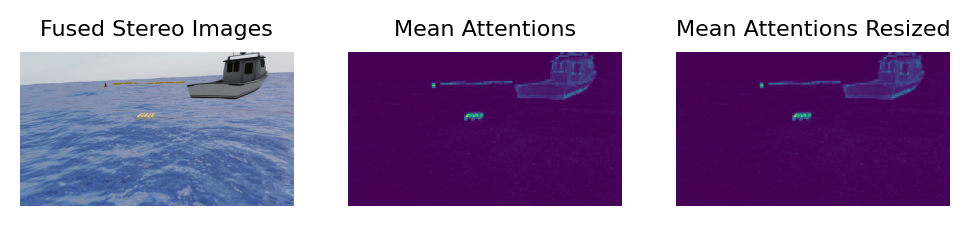

In [16]:
plt.figure(figsize=(6,6), dpi=200)

plt.subplot(1, 3, 1)
plt.title("Fused Stereo Images",size=8)
plt.imshow(imgL)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Mean Attentions",size=8)
plt.imshow(attentions_mean)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Mean Attentions Resized",size=8)
plt.imshow(attentions_mean_resized)
plt.axis("off")

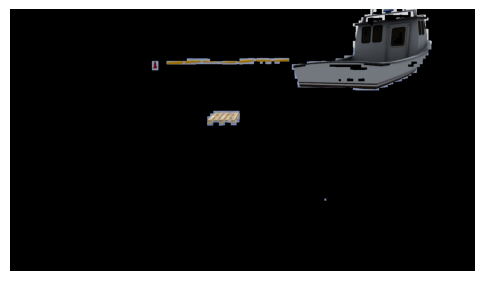

In [17]:
sorted_attention_values = np.sort(attentions_mean_resized.flatten())[::-1]

percentile_65 = int(0.06 * len(sorted_attention_values))
threshold = sorted_attention_values[percentile_65]

binary_mask = (attentions_mean_resized > threshold).astype(np.uint8)

resized_mask = Image.fromarray(binary_mask).resize(fused_image_pil.size, Image.NEAREST)

extracted_objects = np.array(fused_image_pil) * np.expand_dims(resized_mask, axis=2)

plt.figure(figsize=(6,6), dpi=100)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imshow(extracted_objects)

plt.axis('off')
plt.show()

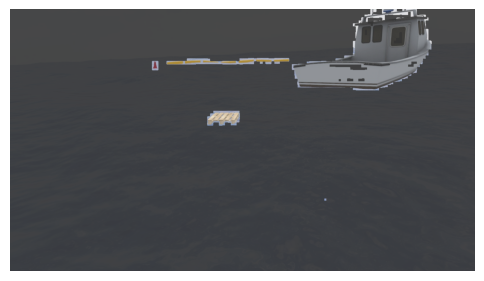

In [18]:
from PIL import Image, ImageEnhance

# Load the original image
original_image = fused_image_pil.convert('RGBA')  # Convert to RGBA for transparency

# Create a transparent overlay (same size as the original image)
overlay = Image.new('RGBA', original_image.size, (255, 255, 255, 0))  # Initialize with fully transparent white

# Set the opacity (adjust as needed)
opacity = 0.7  # Example: 50% transparency

# Blend the original image with the overlay
combined_image = Image.blend(original_image, overlay, opacity)


plt.figure(figsize=(6,6), dpi=100)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imshow(extracted_objects)
plt.imshow(combined_image)

plt.axis('off')
plt.show()

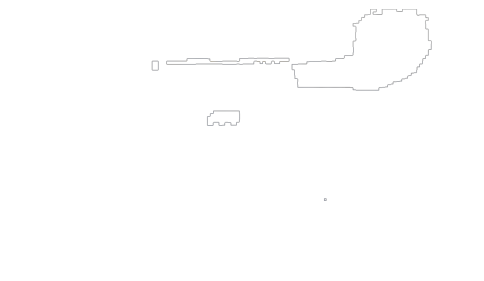

In [19]:
contours, _ = cv.findContours(binary_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

contour_mask = np.zeros_like(binary_mask)

cv.drawContours(contour_mask, contours, -1, 1, thickness=1)

resized_contour_mask = cv.resize(contour_mask, (original_image.width, original_image.height))

contour_highlighted_image = np.array(original_image) * np.expand_dims(resized_contour_mask, axis=2)


plt.figure(figsize=(6,6))
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.imshow(contour_highlighted_image)
plt.axis('off')
plt.show()


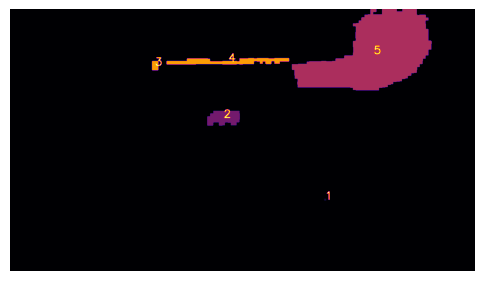

In [21]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'binary_mask' contains your binary mask image

contours, _ = cv.findContours(binary_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

canvas = np.zeros_like(binary_mask)
colors = np.random.randint(0, 256, size=(len(contours), 3))

for i, contour in enumerate(contours):
    # Draw filled contour
    cv.drawContours(canvas, [contour], -1, colors[i].tolist(), thickness=cv.FILLED)
    
    # Calculate bounding box coordinates
    x, y, w, h = cv.boundingRect(contour)
    
    # Draw bounding box
    # cv.rectangle(canvas, (x, y), (x + w, y + h), (255, 255, 255), 2)
    
    # Calculate the centroid of each contour
    M = cv.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        # Draw text indicating object number with increased font size
        cv.putText(canvas, str(i+1), (cX, cY), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

plt.figure(figsize=(6,6))
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.imshow(canvas, cmap="inferno")
plt.axis('off')
plt.show()


In [22]:
import cv2
import numpy as np

# if there were 10 objects, each entry would contain two arrays representing the pixel coordinates for the respective object
object_pixels_list = []


for contour in contours:
    mask = np.zeros_like(binary_mask)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    object_pixels = np.where(mask == 255)
    object_pixels_list.append(object_pixels)

# Access pixel indexes of objects
for i, object_pixels in enumerate(object_pixels_list):
    print(f"Object {i+1} has {len(object_pixels[0])} pixels:")
    # for x, y in zip(object_pixels[0], object_pixels[1]):
        # print(f"Pixel at ({x}, {y})")


Object 1 has 36 pixels:
Object 2 has 3113 pixels:
Object 3 has 464 pixels:
Object 4 has 4179 pixels:
Object 5 has 50706 pixels:


## Depth Estimation

In [23]:
p = np.array([
    [762.7223205566406, 0.0, 640.0, -419.4972763061524],
    [0.0, 762.7223110198975, 360.0, 0.0],
    [0.0, 0.0, 1.0, 0.0]
])

k = np.array([
    [762.7223205566406, 0.0, 640.0],
    [0.0, 762.7223110198975, 360.0],
    [0.0, 0.0, 1.0]
])

t = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
t = np.reshape(t, (-1, 1))

r = np.array([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0]
])

In [24]:
imgL = cv.imread(folder_path + file_name_L)
imgR = cv.imread(folder_path + file_name_R)

imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgL_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)


In [25]:
def compute_left_disparity_map(img_left, img_right, params, matcher_type='bm'):
    
    ### START CODE HERE ###
    img_left_gray = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    img_right_gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    
    if matcher_type == 'bm':
        matcher = cv2.StereoBM_create(params['numDisparities'] , params['blockSize'])
    else:
        matcher = cv2.StereoSGBM_create(**params)
        
    disp_left = matcher.compute(img_left_gray, img_right_gray).astype(np.float32) / 16
    ### END CODE HERE ###
    
    return disp_left

In [26]:
def plot_object_boundary(contours, text=False):
    # Overlay bounding boxes on the left disparity map
    for i, contour in enumerate(contours):
        x, y, w, h = cv.boundingRect(contour)
        centroid_x = x + w // 2
        centroid_y = y + h // 2

        if text:
            plt.text(centroid_x+30, centroid_y-40, f'Obj. {i+1}', color='white', fontsize=8, fontweight='bold', c=colors[i], ha='center', va='center')
        
        # Extract contour coordinates
        contour = np.squeeze(contour)
        contour_x = contour[:, 0]
        contour_y = contour[:, 1]
        
        # Close the contour loop
        contour_x = np.append(contour_x, contour_x[0])
        contour_y = np.append(contour_y, contour_y[0])
        
        # Plot contour using plt.plot()
        plt.plot(contour_x, contour_y, linewidth=2, c=colors[i])




def plot_object_depth(object_pixels_list, depth_map_left):
    # Plot mean depth for each object
    for i, object_pixels in enumerate(object_pixels_list):
        depths = depth_map_left[object_pixels]
        valid_depths = depths[np.isfinite(depths) & (depths >= 0)]
        mean_depth = np.mean(valid_depths)
        centroid = (np.mean(object_pixels[1]), np.mean(object_pixels[0]))
        
        plt.text(centroid[0], centroid[1]-55, f"Obj {i+1}: \n{mean_depth:.0f} m", color=colors[i % len(colors)], fontsize=8, fontweight="bold", ha='center', va='center')


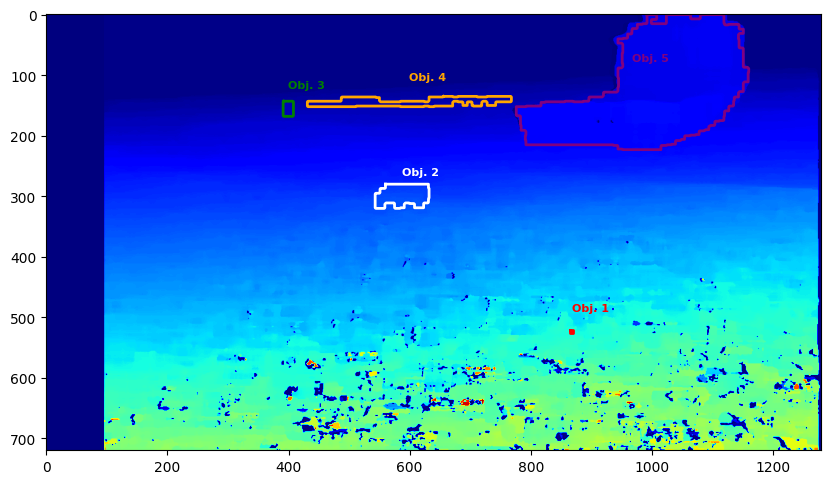

In [27]:
# Compute the disparity map using the fuction above
window_size = 6
params = {
    'minDisparity' : 0,
    'numDisparities': 6 * 16,
    'blockSize' : 11,
    'P1' : 8 * 3 * window_size**2,
    'P2' : 32 * 3 * window_size**2,
    'disp12MaxDiff' : 0,
    'preFilterCap' : 0,
    'uniquenessRatio' : 0,
    'speckleWindowSize' : 0,
    'speckleRange' : 0,
    'mode' : cv2.STEREO_SGBM_MODE_SGBM_3WAY
}

disp_left = compute_left_disparity_map(imgL, imgR, params, matcher_type='sgbm')

plt.figure(figsize=(10, 10))
plt.imshow(disp_left, cmap='jet') 

colors = ['red', 'white', 'green', 'orange', 'purple']

plot_object_boundary(contours, text=True)
plt.show()


In [28]:
def calc_depth_map(disp_left, k_left, b):

    f = k_left[0, 0]
    d = disp_left.copy()
    d[d==0] = 0.1
    d[d==-1] = 0.1
    depth_map = f * b / d
        
    return depth_map

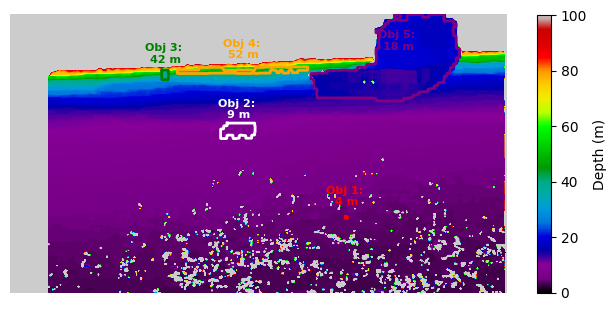

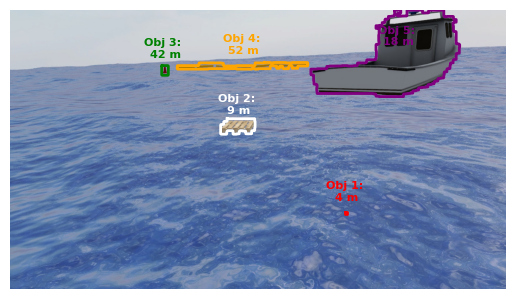

In [29]:
# Get the depth map by calling the above function
depth_map_left = calc_depth_map(disp_left, k, 0.2)

# Display the depth map
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(depth_map_left, cmap='nipy_spectral', clim=[0, 100])
plt.colorbar(label='Depth (m)', shrink=0.45)

# Define colors for edges and text for each object
colors = ['red', 'white', 'green', 'orange', 'purple']


plot_object_boundary(contours, text=False)
plot_object_depth(object_pixels_list, depth_map_left)
plt.axis("off")


plt.show();

plt.imshow(fused_image_pil)
plot_object_boundary(contours, text=False)
plot_object_depth(object_pixels_list, depth_map_left)

plt.axis("off");


In [63]:
for i, object_pixels in enumerate(object_pixels_list):
    depths = depth_map_left[object_pixels]
    valid_depths = depths[np.isfinite(depths) & (depths >= 0)]
    mean_depth = np.mean(valid_depths)

    print(f"Object {i+1} has {len(object_pixels[0])} pixels with a mean depth of {mean_depth:.0f} m")


Object 1 has 3997 pixels with a mean depth of 9 m
Object 2 has 1023 pixels with a mean depth of 42 m
Object 3 has 5977 pixels with a mean depth of 54 m
Object 4 has 53761 pixels with a mean depth of 19 m


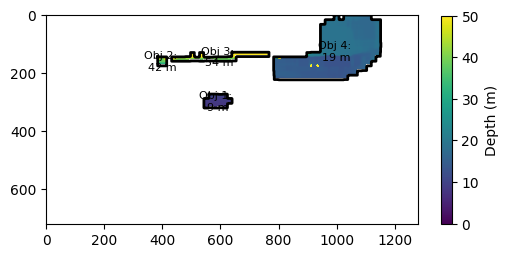

In [64]:
import numpy as np
import matplotlib.pyplot as plt


# Create a mask for all object pixels
object_mask = np.zeros_like(depth_map_left)
for object_pixels in object_pixels_list:
    object_mask[object_pixels] = 1

# Apply the mask to the depth map
masked_depth_map = np.ma.masked_array(depth_map_left, mask=(object_mask == 0))

# Filter out values greater than zero
masked_depth_map[masked_depth_map <= 0] = np.ma.masked

# Plot the masked depth map
plt.figure(figsize=(6,6))
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imshow(masked_depth_map, cmap='viridis', clim=[0, 50])
plt.colorbar(label='Depth (m)', shrink=0.45)

# Plot mean depth for each object
for i, object_pixels in enumerate(object_pixels_list):
    depths = depth_map_left[object_pixels]
    valid_depths = depths[np.isfinite(depths) & (depths >= 0)]
    mean_depth = np.mean(valid_depths)
    centroid = (np.mean(object_pixels[1]), np.mean(object_pixels[0]))
    plt.text(centroid[0], centroid[1], f"Obj {i+1}: \n{mean_depth:.0f} m", color='black', fontsize=8, ha='center', va='center')



# Overlay bounding boxes on the left disparity map
for i, contour in enumerate(contours):
    x, y, w, h = cv.boundingRect(contour)
    centroid_x = x + w // 2
    centroid_y = y + h // 2
    
    # Extract contour coordinates
    contour = np.squeeze(contour)
    contour_x = contour[:, 0]
    contour_y = contour[:, 1]
    
    # Close the contour loop
    contour_x = np.append(contour_x, contour_x[0])
    contour_y = np.append(contour_y, contour_y[0])
    
    # Plot contour using plt.plot()
    plt.plot(contour_x, contour_y, linewidth=2, c="k")

plt.show()



In [ ]:
def depth_to_pointcloud(K: np.ndarray, depth: np.ndarray, rgb: np.ndarray = None):
    """Convert depth image to pointcloud given camera intrinsics.
    Args:
        depth (np.ndarray): Depth image.
    Returns:
        np.ndarray: (x, y, z) Point cloud. [n, 4]
        np.ndarray: (r, g, b) RGB colors per point. [n, 3] or None
    """
    _fx = K[0, 0]
    _fy = K[1, 1]
    _cx = K[0, 2]
    _cy = K[1, 2]

    # Mask out invalid depth
    mask = np.where(depth > 0)
    x, y = mask[1], mask[0]

    # Normalize pixel coordinates
    normalized_x = x.astype(np.float32) - _cx
    normalized_y = y.astype(np.float32) - _cy

    # Convert to world coordinates
    world_x = normalized_x * depth[y, x] / _fx
    world_y = normalized_y * depth[y, x] / _fy
    world_z = depth[y, x]

    pc = np.vstack((world_x, world_y, world_z)).T

    # Assign rgb colors to points if available
    if rgb is not None:
        rgb = rgb[y, x, :]

    # return pc, rgb
    return world_x, world_y, world_z


x, y, z = depth_to_pointcloud(k, depth_map_left, imgL)
# x, y, z = depth_to_pointcloud(k, masked_depth_map, imgL)


# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z, s=1)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()